In [1]:
# imports
import os
import json
import re

import torch 
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import numpy as np

from MDP import MDP

import stable_baselines3
import sb3_contrib

import gym

In [2]:
# check torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3080'

In [3]:
#load MDP
mdp = MDP(dir = "data_medium", type = "val", name = "100595")
# show grid
done = False
for a in ["move", "putMarker", "move"]:
    if done:
        break
    nextState, rew, done, b = mdp.sample_next_state_and_reward(a)
    mdp.print_grid()
    print(rew)
mdp.print_grid()

[[['.' '.' '.' '#']
  ['v' '#' '#' '#']
  ['.' '#' '.' '#']
  ['#' '#' '#' '#']]

 [['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]]
0.01
[[['.' '.' '.' '#']
  ['d' '#' '#' '#']
  ['.' '#' '.' '#']
  ['#' '#' '#' '#']]

 [['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]]
0.1
[[['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]

 [['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]]
0.01
[[['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]

 [['.' '.' '.' '#']
  ['O' '#' '#' '#']
  ['v' '#' '.' '#']
  ['#' '#' '#' '#']]]


## Initialize Model with Imitation learning

In [3]:
# create dataset

#numerical representation of actions
getNumAction = {
    "move" : 0,
    "turnRight": 1,
    "turnLeft" : 2,
    "pickMarker": 3,
    "putMarker" : 4,
    "finish" : 5
}

class Dataset(data.Dataset):
    """
    attributes:
    dir : str list :=  accepted directories (data, data_easy, data_medium)
    type : str list := train and/or val
    grid : tensor := a tensor of all available grids
    actions : tensor := vector of the optimal action for each
    """
    def data_generator(self):
        for dir in self.dir:
            for type in self.type:
                for i in os.listdir(os.sep.join(["datasets", dir, type, "task"]))[:-4]:
                    i = re.sub(r"\D", "", i)
                    # load MDP and optimal sequence
                    currMDP = MDP(dir = dir, type = type, name = str(i))

                    with open(os.sep.join(["datasets", dir, type, "seq", str(i) + "_seq.json"])) as seq:
                        sequence = json.load(seq)["sequence"]
                    
                    for action in sequence:
                        yield currMDP.get_current_state().copy(), action
                        currMDP.get_next_state(action)


    def __init__(self, dir = ["data", "data_easy", "data_medium"], type = ["train"]) -> None:
        """
        dir : str list :=  accepted directories (data, data_easy, data_medium)
        type : str list := train and/or val
        """
        self.dir = dir
        self.type = type
        lstActionsAndGrids = list(self.data_generator())
        self.grid = torch.tensor(np.array([x[0] for x in lstActionsAndGrids]) / 10, device= device)
        self.actions = torch.tensor(np.array([getNumAction[x[1]] for x in lstActionsAndGrids]), device= device)
    
    def __len__(self):
        return len(self.grid)

    def __getitem__(self, idx):
        return self.grid[idx], self.actions[idx]

trainDataset = Dataset()
valDataset = Dataset(type = ["val"])
print(len(trainDataset))

171921


In [4]:
# create Neural Network

class Net(nn.Module):
    """
    input : 2 X 4 X 4 grid
    label : Move [0;6]
    """
    def __init__(self):
        super(Net, self).__init__()
        # first layer: input
        self.conv1 = nn.Conv2d(2, 8, 2)

        #second layer : 2nd convolution
        self.conv2 = nn.Conv2d(8, 16, 2)

        self.conv3 = nn.Conv2d(16, 32, 1)

        self.fc1 = nn.Linear(128, 32)

        self.out = nn.Linear(32, 6)


    def forward(self, x):
        x = x.float()

        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        x = torch.flatten(x,start_dim=1)

        x = F.relu(self.fc1(x))

        x = self.out(x)
    
        return x    

In [23]:
#creating model
net = Net()
net.cuda()
print(net)

params = list(net.parameters())
print(f"number of parameters: {len(params)}")

#loss function
loss = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(net.parameters())
optimizer

Net(
  (conv1): Conv2d(2, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=6, bias=True)
)
number of parameters: 10


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [25]:
net.load_state_dict(torch.load("Net"))

<All keys matched successfully>

In [7]:
BATCH_SIZE = 16
dataloader = data.DataLoader(trainDataset, BATCH_SIZE)
validationLoader = data.DataLoader(valDataset, BATCH_SIZE)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        lossVal = loss(outputs, labels)
        lossVal.backward()

        optimizer.step()

        running_loss += lossVal.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [8]:
timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
writer = SummaryWriter("runs/imitation_learning_{}".format(timestamp))
epoch_num = 0

torch.manual_seed(666)

EPOCHS = 16

for epoch in range(EPOCHS):
    print("EPOCH {}".format(epoch_num + 1))

    net.train(True)
    avg_loss = train_one_epoch(epoch_num, writer)

    net.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validationLoader):
        vinputs, vlabels = vdata
        vout = net(vinputs)
        vloss = loss(vout, vlabels)
        running_vloss += vloss
    avg_vloss = running_vloss / (i+1)
    print(f"Loss train {avg_loss} validation {avg_vloss}")


    writer.add_scalars("Training Loss", {"Training" : avg_loss, "validation" : avg_vloss})
    writer.flush()

    epoch_num += 1

EPOCH 1
  batch 1000 loss: 1.5783008595705033
  batch 2000 loss: 1.3749266838431358
  batch 3000 loss: 1.1718439801335334
  batch 4000 loss: 1.1124092612862586
  batch 5000 loss: 1.0733981890678406
  batch 6000 loss: 1.0469628486037255
  batch 7000 loss: 1.02333509516716
  batch 8000 loss: 0.8093265895545483
  batch 9000 loss: 0.9308073059618474
  batch 10000 loss: 0.8976528417766094
Loss train 0.8976528417766094 validation 0.9877560138702393
EPOCH 2
  batch 1000 loss: 0.9853208666443825
  batch 2000 loss: 0.9581440341472626
  batch 3000 loss: 0.9396988725364208
  batch 4000 loss: 0.9498062210083008
  batch 5000 loss: 0.9444123804867267
  batch 6000 loss: 0.9492995936870575
  batch 7000 loss: 0.9222798682749271
  batch 8000 loss: 0.6923998926579952
  batch 9000 loss: 0.7688756507188081
  batch 10000 loss: 0.7479797872751951
Loss train 0.7479797872751951 validation 1.610937476158142
EPOCH 3
  batch 1000 loss: 0.9053105400502681
  batch 2000 loss: 0.8609425539374351
  batch 3000 loss: 0.

In [11]:
torch.save(net.state_dict(), "Net")

In [9]:
# test model
actions = ["move", "turnRight", "turnLeft", "pickMarker", "putMarker", "finish"]

testMDP = MDP(dir = "data", type = "val", name = "100112")

def apply_to_grid(MDP, show_grid):
    reward = 0
    steps = 0
    if show_grid:
        MDP.print_grid()
    while True:
        current_grid = torch.tensor(MDP.get_current_state(), device= device) / 10
        out = net(current_grid.unsqueeze(0))
        nextAction = actions[torch.argmax(out)]
        reward += MDP.gamma**steps * MDP.reward(nextAction)
        steps += 1
        if MDP.get_next_state(nextAction) == "Terminal" or steps > 100:
            return reward, steps, MDP.task_solved()
        if show_grid:
            print("action: {}, reward: {}".format(nextAction, reward))
            MDP.print_grid()


apply_to_grid(testMDP, True)

[[['>' '.' '.' 'O']
  ['#' '#' '.' '#']
  ['.' '#' '.' '#']
  ['.' '#' '#' '#']]

 [['.' '.' '.' '^']
  ['#' '#' '.' '#']
  ['.' '#' '.' '#']
  ['.' '#' '#' '#']]]


(-0.1, 1, False)

In [21]:
# check accuracy of solved tasks
sucesses = 0
for dir in ["data", "data_easy", "data_medium"]:
    for type in ["val"]:
        for i in os.listdir(os.sep.join(["datasets", dir, type, "task"]))[:-4]:
            i = re.sub(r"\D", "", i)
            curr_MDP = MDP(dir, type, i)
            if apply_to_grid(curr_MDP, False)[-1]:
                sucesses += 1

print("tasks solved with only imitation learning:")
print(f"Total : {sucesses}, accuracy: {sucesses *100 / len(valDataset)}%")

TypeError: 'collections.OrderedDict' object is not callable

As it is clearly seen here, imitation learning with the limited amount of training data is not able to solve most of the provided tasks. Therefore, in the following I will use the described PPO approach and after that will create the final model that uses imitation learning to initiate the model and then trains it with maskless PPO to achieve the best possible performance.

In [12]:
# test generated MDPs
test = np.random.randint(1, 1e5)

genMDP = MDP("generated", "train", str(test))

genMDP.print_grid()

[[['.' '>' '.' '.']
  ['.' '.' '.' '.']
  ['O' '.' '.' '.']
  ['.' 'O' '.' '.']]

 [['.' '<' 'O' '.']
  ['.' '.' '.' '.']
  ['O' '.' '.' '.']
  ['.' 'O' '.' '.']]]


In [12]:
#custom environment
from gym import spaces

class Gridworld(gym.Env):

    metadata = {"render.modes" : ["human"]}

    def MDP_generator(self):
        while True:
            for dir in self.dir:
                for type in self.type:
                    for i in os.listdir(os.sep.join(["datasets", dir, type, "task"]))[:-4]:
                        i = re.sub(r"\D", "", i)
                        yield dir, type, i

    def __init__(self, dir = ["data", "data_easy", "data_medium"], type = ["train"], lambda1 = 0.01, lambda2 = 0.1, lambda3 = 1) -> None:
        super(Gridworld, self).__init__()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low = 0, high = 10, shape = (2, 4, 4))

        #available MDPs
        self.dir = dir
        self.type = type
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3



        self.next_MDP = self.MDP_generator()
        self.actions = ["move", "turnLeft", "turnRight", "pickMarker", "putMarker", "finish"]

    def reset(self):
        self.nextDir, self.nextType, self.nexti =  next(self.next_MDP)
        self.currentMDP = MDP(self.nextDir, self.nextType, self.nexti, lambda1= self.lambda1, lambda2 = self.lambda2, lambda3 =self.lambda3)
        return self.currentMDP.get_current_state()

    def step(self, action):
        nextState, rew, done, info = self.currentMDP.sample_next_state_and_reward(self.actions[action])

        return nextState, rew, done, info 
        
    def render(self):
        self.currentMDP.print_grid()

    def close(self):
        pass
    
    def action_masks(self):
        return self.currentMDP.action_mask()

    # functions bellow are only used for inheritance 
    def get_MDP(self):
        return self.currentMDP

    def get_MDP_name(self):
        return self.nextDir, self.nextType, self.nexti

In [18]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

testEnv = Gridworld()

In [57]:
env = make_vec_env(Gridworld, n_envs= 4, env_kwargs={"lambda1" : 0})

model = PPO("MlpPolicy", env, verbose = 1, gamma= 1)
model.learn(5 * 1e5)


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.53     |
|    ep_rew_mean     | -0.384   |
| time/              |          |
|    fps             | 4664     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.84        |
|    ep_rew_mean          | -0.272      |
| time/                   |             |
|    fps                  | 2487        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.067049526 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | -1.52       |
|    learnin

In [71]:
test = testEnv.reset()
testEnv.render()

[[['#' '.' '.' '.']
  ['.' '.' '#' '.']
  ['.' '^' '.' '.']
  ['.' '#' '.' '#']]

 [['#' '.' '.' '.']
  ['.' '.' '#' '.']
  ['v' '.' '.' '.']
  ['.' '#' '.' '#']]]


In [72]:
action = model.predict(test, deterministic= True)[0]
print(action)
test, rew, done, _ = testEnv.step(action)
print(rew, done)
testEnv.render()

2
0 False
[[['#' '.' '.' '.']
  ['.' '.' '#' '.']
  ['.' '>' '.' '.']
  ['.' '#' '.' '#']]

 [['#' '.' '.' '.']
  ['.' '.' '#' '.']
  ['v' '.' '.' '.']
  ['.' '#' '.' '#']]]


In [29]:
def test_RL_models(model):
    valDataset = GridworldForcedFinished(type = ["val"], lambda1=0, lambda2=0)
    correct, total = 0,10000
    for task in range(int(total)):
        if task % 500 == 499:
            print(f"{(task+1) / total *100} %, running acc: {(correct*100)/(task+1)}")
        currMDP = valDataset.reset()
        done = False
        steps = 0
        while not done and steps < 100:
            action = model.predict(currMDP, action_masks = valDataset.action_masks(), deterministic = True)[0]
            currMDP, rew, done, _ = valDataset.step(action)
            if rew > 0:
                correct += 1
            steps += 1
            
            
    print(f"correct : {correct}, accuracy: {(correct*100)/total } %")
    return (correct*100)/total

In [65]:
test_RL_models(model)

NameError: name 'model' is not defined

The normal PPO model performs even worse then the Imitation learning model. This could be improved with some tuning, but I instead will focus on the maskable PPO model.

# Maskable PPO

In [14]:
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.ppo_mask import MaskablePPO
from stable_baselines3.common.env_util import make_vec_env

In [62]:
maskEnv = make_vec_env(Gridworld, n_envs = 8)

modelMask = MaskablePPO(MaskableActorCriticPolicy, maskEnv, verbose = 1, gamma = 1)
modelMask.learn(1e5)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.9     |
|    ep_rew_mean     | -0.161   |
| time/              |          |
|    fps             | 5394     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -0.181      |
| time/                   |             |
|    fps                  | 2414        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.012206229 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | -2.36       |
|    learnin

In [76]:
testEnv = Gridworld()

In [77]:
test = testEnv.reset()
testEnv.render()

[[['#' '.' '.' '#']
  ['#' '.' '#' '.']
  ['.' '^' 'O' '.']
  ['.' '.' '#' '.']]

 [['#' '.' '.' '#']
  ['#' '^' '#' '.']
  ['.' '.' 'O' '.']
  ['.' '.' '#' '.']]]


In [79]:
action = modelMask.predict(test, action_masks=testEnv.action_masks(), deterministic= True)[0]
print(action)
test, rew, done, _ = testEnv.step(action)
print(rew, done)
testEnv.render()

5
1 True
[[['#' '.' '.' '#']
  ['#' '^' '#' '.']
  ['.' '.' 'O' '.']
  ['.' '.' '#' '.']]

 [['#' '.' '.' '#']
  ['#' '^' '#' '.']
  ['.' '.' 'O' '.']
  ['.' '.' '#' '.']]]


In [80]:
test_RL_models(modelMask)

999.0001 %
1999.0001 %
2999.0001 %
3999.0001 %
4999.0001 %
5999.0001 %
6999.0001 %
7999.0001 %
8999.0001 %
9999.0001 %
correct : 13, accuracy: 0.13 %


Additionally I will try using a action mask that forces the agent to use the finish command if possible

In [15]:
class GridworldForcedFinished(Gridworld):
    def __init__(self, dir=["data", "data_easy", "data_medium"], type=["train"], lambda1=0.01, lambda2=0.1, lambda3=1) -> None:
        super().__init__(dir, type, lambda1, lambda2, lambda3)

    def action_masks(self):
        mat = super().get_MDP().get_current_state()
        if np.array_equal(mat[0], mat[1]):
            return np.array([0,0,0,0,0,1])

        return super().action_masks()

In [37]:
testEnv = GridworldForcedFinished()
testEnv.reset()
testEnv.step(0)
testEnv.render()
testEnv.action_masks()

[[['#' '.' '.' '#']
  ['#' '^' '#' '.']
  ['.' '.' 'O' '.']
  ['.' '.' '#' '.']]

 [['#' '.' '.' '#']
  ['#' '^' '#' '.']
  ['.' '.' 'O' '.']
  ['.' '.' '#' '.']]]


array([0, 0, 0, 0, 0, 1])

In [38]:
envForcedFinish = make_vec_env(GridworldForcedFinished, n_envs=8, env_kwargs={"lambda1" : 0})

modelForcedFinish = MaskablePPO(MaskableActorCriticPolicy, envForcedFinish, verbose= 1, gamma= 1)
modelForcedFinish.learn(1e5)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -0.073   |
| time/              |          |
|    fps             | 4343     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 16384    |
---------------------------------


KeyboardInterrupt: 

In [39]:
test = testEnv.reset()
testEnv.render()

[[['.' '#' '.' '.']
  ['.' '#' '<' '#']
  ['.' '#' '.' '.']
  ['.' '#' '.' '.']]

 [['.' '#' '.' '.']
  ['.' '#' '.' '#']
  ['.' '#' 'v' '.']
  ['.' '#' '.' '.']]]


In [40]:
action = modelForcedFinish.predict(test, action_masks=testEnv.action_masks(), deterministic= True)[0]
print(action)
test, rew, done, _ = testEnv.step(action)
print(rew, done)
testEnv.render()

1
0 False
[[['.' '#' '.' '.']
  ['.' '#' 'v' '#']
  ['.' '#' '.' '.']
  ['.' '#' '.' '.']]

 [['.' '#' '.' '.']
  ['.' '#' '.' '#']
  ['.' '#' 'v' '.']
  ['.' '#' '.' '.']]]


In [41]:
test_RL_models(modelForcedFinish)

NameError: name 'test_RL_models' is not defined

The accuracy did improve, but it is still far from perfect

# imitation learning with PPO

In [15]:
actions = {"move" : 0,
           "turnLeft" : 1,
           "turnRight": 2,
           "pickMarker": 3,
           "putMarker": 4,
           "finish": 5}


class GridworldImitation(Gridworld):
    """
    Gridworld that applies the action mask by forcing the agent to take the optimal action. This is used to kickstart the training of an agent for randomly generated tasks.
    NOTE: can only be used for train and val data.
    NOTE: Lambda 1 is set to 0
    """
    def __init__(self, dir=["data", "data_easy", "data_medium"], type=["train"], lambda1=0, lambda2=0.1, lambda3=1) -> None:
        super().__init__(dir, type, lambda1, lambda2, lambda3)


    def reset(self):
        res = super().reset()
        dir, type, i = super().get_MDP_name()
        with open(os.sep.join(["datasets", dir, type, "seq", i + "_seq.json"])) as grid:
            grid = json.load(grid)
            self.optimal_seq = grid["sequence"]
            # current step
            assert self.optimal_seq[-1] == "finish"
            self.n = 0
        return res

    def action_masks(self):
        mask = np.zeros(6)
        mask[actions[self.optimal_seq[self.n]]] = 1
        self.n += 1
        return mask

In [187]:
imitationEnv = make_vec_env(GridworldImitation, n_envs= 8, env_kwargs={"lambda1" : 0})

ImitationModel = MaskablePPO(MaskableActorCriticPolicy, imitationEnv, verbose= 1,n_epochs = 14, gamma=1)
# train for 14 epochs
ImitationModel.learn(1e5)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.84     |
|    ep_rew_mean     | 0.896    |
| time/              |          |
|    fps             | 4279     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 16384    |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 5         |
|    ep_rew_mean          | 0.884     |
| time/                   |           |
|    fps                  | 1666      |
|    iterations           | 2         |
|    time_elapsed         | 19        |
|    total_timesteps      | 32768     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | 0         |
|    explained_variance   | -0.775    |
|    learning_rate        | 0.0003    |
| 

In [248]:
test_RL_models(ImitationModel)

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
correct : 184, accuracy: 1.84 %


In [199]:
testEnv = GridworldForcedFinished()

In [242]:
test = testEnv.reset()
testEnv.render()

[[['>' '#' '#' '.']
  ['.' 'O' '#' '.']
  ['.' '#' '.' '.']
  ['.' '.' '#' '.']]

 [['.' '#' '#' '.']
  ['O' 'O' '#' '.']
  ['<' '#' '.' '.']
  ['.' '.' '#' '.']]]


In [247]:
action = ImitationModel.predict(test, action_masks=testEnv.action_masks(), deterministic= True)[0]
print(action)
test, rew, done, _ = testEnv.step(action)
print(rew, done)
testEnv.render()

2
0 False
[[['^' '#' '#' '.']
  ['.' 'O' '#' '.']
  ['.' '#' '.' '.']
  ['.' '.' '#' '.']]

 [['.' '#' '#' '.']
  ['O' 'O' '#' '.']
  ['<' '#' '.' '.']
  ['.' '.' '#' '.']]]


# Imitation Learning using a Custom Network

In [16]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
import torch.nn.functional as F

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 32):
        super().__init__(observation_space, features_dim)

        self.conv1 = nn.Conv2d(2, 8, 3)

        self.conv2 = nn.Conv2d(8, 32, 2)

        self.conv3 = nn.Conv2d(32, 64, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))

        x = torch.flatten(x, start_dim= 1)

        return x

net_arch = [
    32,16, 8,
    dict(vf = [8,4], pi = [8,4])
]

policy_kwargs = dict(
    features_extractor_class = CustomFeatureExtractor,
    net_arch = net_arch
)



In [17]:
imitationEnv =make_vec_env(GridworldImitation, n_envs= 4)

ImitationModelCustom = MaskablePPO(MaskableActorCriticPolicy, imitationEnv, policy_kwargs= policy_kwargs, verbose= 1)
# train for 14 epochs
ImitationModelCustom.learn(1e5)

NameError: name 'GridworldImitation' is not defined

In [319]:
test_RL_models(ImitationModelCustom)

20.0 %
40.0 %
60.0 %
80.0 %
100.0 %
correct : 2, accuracy: 0.04 %


# Using the trained Imitation model as a base

In [18]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sb3_contrib.ppo_mask import MaskablePPO
from stable_baselines3.common.env_util import make_vec_env

import torch.nn.functional as F
from torch import nn

class CustomFeatureExtractorTorch(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 128):
        super().__init__(observation_space, features_dim)

        self.conv1 = net.conv1
        self.conv2 = net.conv2
        self.conv3 = net.conv3

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        return x

net_arch = [
    32, 16, 8,
    dict(vf = [8,4], pi = [8,4])
]

policy_kwargs = dict(
    features_extractor_class = CustomFeatureExtractorTorch,
    net_arch = net_arch
)

In [19]:
imitationEnvTorch = make_vec_env(GridworldForcedFinished, n_envs= 4, env_kwargs={"lambda1" : 0, "lambda2" : 0})

modelImitationTorch = MaskablePPO(MaskableActorCriticPolicy, imitationEnvTorch, policy_kwargs= policy_kwargs,  verbose = 1, gamma = 0.25)

modelImitationTorch.learn(3 * 1e5)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 0.1      |
| time/              |          |
|    fps             | 2597     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 0.05         |
| time/                   |              |
|    fps                  | 1297         |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0035834848 |
|    clip_fraction        | 0.000671     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | -33.8       

KeyboardInterrupt: 

In [39]:
modelImitationTorch.learn(1e5 * 3)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 0.739    |
| time/              |          |
|    fps             | 2559     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 252          |
|    ep_rew_mean          | 0.568        |
| time/                   |              |
|    fps                  | 1341         |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0051238844 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 0.0146       |
|    learning_r

KeyboardInterrupt: 

In [22]:
test_RL_models(modelImitationTorch)

20.0 %
40.0 %
60.0 %
80.0 %
100.0 %
correct : 872, accuracy: 17.44 %


This way of doing hybrid imitation learning and PPO does have much better performance. Also, the simplified reward function does improve training by a lot.

# Test hyperparameters

gamma values

In [27]:
gamma_vals = [0.25, 0.4, 0.5, 0.75, 0.85, 0.99]
res = []

for gamma in gamma_vals:
    print(f"current gamma: {gamma}")
    testing_env = make_vec_env(GridworldForcedFinished, n_envs= 6, env_kwargs={"lambda1" : 0, "lambda2" : 0})

    currModel = MaskablePPO(MaskableActorCriticPolicy, testing_env, policy_kwargs= policy_kwargs,  verbose = 0, gamma = 0.25)

    currModel.learn(5 * 1e5)

    res.append(test_RL_models(currModel))


current gamma: 0.25
40.0 %
80.0 %
correct : 207, accuracy: 8.28 %
current gamma: 0.4
40.0 %
80.0 %
correct : 51, accuracy: 2.04 %
current gamma: 0.5
40.0 %
80.0 %
correct : 114, accuracy: 4.56 %
current gamma: 0.75
40.0 %
80.0 %
correct : 397, accuracy: 15.88 %
current gamma: 0.85
40.0 %
80.0 %
correct : 226, accuracy: 9.04 %
current gamma: 0.99
40.0 %
80.0 %
correct : 222, accuracy: 8.88 %


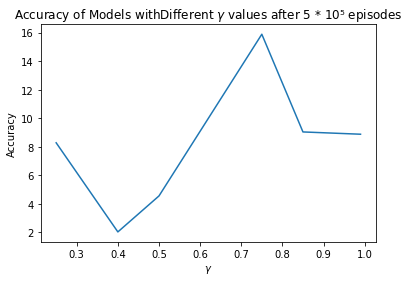

In [32]:
import matplotlib.pyplot as plt

plt.plot(gamma_vals, res)
plt.ylabel("Accuracy")
plt.xlabel("$\gamma$")
plt.title("Accuracy of Models withDifferent $\gamma$ values after 5 * 10⁵ episodes")
plt.show()

In [26]:
net_arch = [
    128, 64, 16, 8,
    dict(vf = [8, 4, 2], pi = [8, 4, 2])
]

policy_kwargs = dict(
    features_extractor_class = CustomFeatureExtractorTorch,
    net_arch = net_arch
)

In [27]:
FinalEnv = make_vec_env(GridworldForcedFinished, n_envs= 4, env_kwargs={"lambda1" : 0, "lambda2" : 0, "dir" : ["data_easy", "data_medium", "data",  "generated"]})

FinalModel = MaskablePPO(MaskableActorCriticPolicy, FinalEnv, policy_kwargs= policy_kwargs,  verbose = 1, gamma = 0.75)

FinalModel.learn(1e6)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.47     |
|    ep_rew_mean     | 0.29     |
| time/              |          |
|    fps             | 2405     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 0.41        |
| time/                   |             |
|    fps                  | 1190        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008212661 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | -2.26       |
|    learnin

KeyboardInterrupt: 

In [42]:
FinalModel.learn(1e6)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 54.7     |
|    ep_rew_mean     | 0.0558   |
| time/              |          |
|    fps             | 2600     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 62.3        |
|    ep_rew_mean          | -0.0226     |
| time/                   |             |
|    fps                  | 1257        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012740752 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.452      |
|    explained_variance   | -0.0638     |
|    learning_rate        | 0.

In [30]:
test_RL_models(FinalModel)

5.0 %, running acc: 27.0
10.0 %, running acc: 27.9
15.0 %, running acc: 27.8
20.0 %, running acc: 28.85
25.0 %, running acc: 30.72
30.0 %, running acc: 36.03333333333333
35.0 %, running acc: 36.34285714285714
40.0 %, running acc: 36.7
45.0 %, running acc: 35.68888888888889
50.0 %, running acc: 34.98
55.00000000000001 %, running acc: 34.30909090909091
60.0 %, running acc: 34.06666666666667
65.0 %, running acc: 34.50769230769231
70.0 %, running acc: 36.42857142857143
75.0 %, running acc: 36.53333333333333
80.0 %, running acc: 36.7125
85.0 %, running acc: 36.16470588235294
90.0 %, running acc: 35.74444444444445
95.0 %, running acc: 35.32631578947368
100.0 %, running acc: 35.15
correct : 3515, accuracy: 35.15 %


35.15